In [1]:
!nvidia-smi

Fri Sep 22 06:00:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:00:05.0 Off |                  Off |
| 30%   32C    P8    25W / 300W |      1MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q pyspellchecker textstat

In [3]:
!pip install lightgbm==3.3.2

In [4]:
import os

class Config:
    AUTHOR = "wanwan7123"

    NAME = "commonlit-exp021-deberta-v3-large"
    MODEL_PATH = "microsoft/deberta-v3-large"
    ROOT = "/notebooks"

    apex=True
    seed = 42
    num_fold = 4
    trn_fold = [0, 1, 2, 3]
    batch_size = 16
    n_epochs = 3
    max_len = 1024
    target_list = ["content", "wording"]
    
    weight_decay = 0.01
    scheduler='cosine'
    betas = (0.9, 0.999)
    encoder_lr = 2e-5
    decoder_lr = 3e-5
    lr_weight_decay = 0.98
    min_lr = 1e-6
    eps = 1e-6
    eval_step = 80
    num_cycles=0.5
    num_warmup_steps_rate=0
    clip_grad_norm = 1000
    gradient_accumulation_steps = 1
    
    # GPU Optimize Settings
    gpu_optimize_config= {
        "freezing": True,
        "gradient_checkpoint": True
    }
        
    model_params = {
        "objective": "rmse",
        "metric": "regression",
        "verbosity": -1,
        "learning_rate": 0.01,
        "random_state": seed,
        "feature_fraction": 0.85,
        "lambda_l1": 0.1,
        "lambda_l2": 0.1,
    }
    
    lgb_train_params = {
        "num_boost_round": 999999,
    }

In [5]:
import os
import re
import gc
import sys
import json
import time
import shutil
import joblib
import random
import requests
import warnings
warnings.filterwarnings('ignore')
from ast import literal_eval
from tqdm.auto import tqdm
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import scipy 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    StratifiedKFold, 
    KFold, 
    GroupKFold,
    StratifiedGroupKFold
)
from sklearn.metrics import mean_squared_error

from spellchecker import SpellChecker
import textstat
import lightgbm as lgb

! pip install torch==1.10.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.checkpoint import checkpoint
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

!pip install text-unidecode

Looking in links: https://download.pytorch.org/whl/torch_stable.html


# utils

In [6]:
def setup(cfg):
    cfg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # pip install
    ! pip install -qq transformers==4.16.2
    ! pip install -qq tokenizers==0.11.6
    ! pip install -qq transformers[sentencepiece]

    # set dirs    
    cfg.INPUT = Path(f"{cfg.ROOT}/input")
    cfg.OUTPUT = Path(f"{cfg.ROOT}/output")
    cfg.EXP = cfg.OUTPUT / cfg.NAME

    cfg.api_path = f"{cfg.ROOT}/kaggle.json"

    cfg.EXP_MODEL = cfg.EXP / "model"
    cfg.EXP_FIG = cfg.EXP / "fig"
    cfg.EXP_PREDS = cfg.EXP / "preds"

    # make dirs
    for d in [cfg.EXP, cfg.EXP_MODEL, cfg.EXP_FIG, cfg.EXP_PREDS]:
        d.mkdir(exist_ok=True)
        
    # use kaggle api (need kaggle token)
    f = open(cfg.api_path, 'r')
    json_data = json.load(f) 
    os.environ['KAGGLE_USERNAME'] = json_data['username']
    os.environ['KAGGLE_KEY'] = json_data['key']
    
    return cfg

def dataset_create_new(dataset_name, upload_dir):
    dataset_metadata = {}
    dataset_metadata['id'] = f'{os.environ["KAGGLE_USERNAME"]}/{dataset_name}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = dataset_name
    with open(os.path.join(upload_dir, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode='tar')

In [7]:
# =====================
# Utils
# =====================
# Seed
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# KFold
def get_kfold(train, n_splits, seed):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train)
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_stratifiedkfold(train, target_col, n_splits, seed):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_groupkfold(train, target_col, group_col, n_splits):
    kf = GroupKFold(n_splits=n_splits)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_groupstratifiedkfold(train, target_col, group_col, n_splits, seed):
    kf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_multilabelstratifiedkfold(train, target_col, n_splits, seed):
    kf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_commonlit_fold(train):
    id2fold = {
        "814d6b": 0,
        "39c16e": 1,
        "3b9047": 2,
        "ebad26": 3,
    }
    train["fold"] = train["prompt_id"].map(id2fold)
    return train["fold"]

In [8]:
def mcrmse(cfg, preds, df, verbose = True):
    all_score = 0
    for i, column in enumerate(cfg.target_list):
        score = np.sqrt(mean_squared_error(preds[:, i], df[column]))
        if verbose:
            print(f"{column} rmse:", score)
        all_score += score/len(cfg.target_list)
    return all_score

# preprocess

In [9]:
from text_unidecode import unidecode
from typing import Dict, List, Tuple
import codecs

def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

In [10]:
misspell_mapping = {
    'studentdesigned': 'student designed',
    'teacherdesigned': 'teacher designed',
    'genericname': 'generic name',
    'winnertakeall': 'winner take all',
    'studentname': 'student name',
    'driveless': 'driverless',
    'teachername': 'teacher name',
    'propername': 'proper name',
    'bestlaid': 'best laid',
    'genericschool': 'generic school',
    'schoolname': 'school name',
    'winnertakesall': 'winner take all',
    'elctoral': 'electoral',
    'eletoral': 'electoral',
    'genericcity': 'generic city',
    'elctors': 'electoral',
    'venuse': 'venue',
    'blimplike': 'blimp like',
    'selfdriving': 'self driving',
    'electorals': 'electoral',
    'nearrecord': 'near record',
    'egyptianstyle': 'egyptian style',
    'oddnumbered': 'odd numbered',
    'carintensive': 'car intensive',
    'elecoral': 'electoral',
    'oction': 'auction',
    'electroal': 'electoral',
    'evennumbered': 'even numbered',
    'mesalandforms': 'mesa landforms',
    'electoralvote': 'electoral vote',
    'relativename': 'relative name',
    '22euro': 'twenty two euro',
    'ellectoral': 'electoral',
    'thirtyplus': 'thirty plus',
    'collegewon': 'college won',
    'hisher': 'higher',
    'teacherbased': 'teacher based',
    'computeranimated': 'computer animated',
    'canadidate': 'candidate',
    'studentbased': 'student based',
    'gorethanks': 'gore thanks',
    'clouddraped': 'cloud draped',
    'edgarsnyder': 'edgar snyder',
    'emotionrecognition': 'emotion recognition',
    'landfrom': 'land form',
    'fivedays': 'five days',
    'electoal': 'electoral',
    'lanform': 'land form',
    'electral': 'electoral',
    'presidentbut': 'president but',
    'teacherassigned': 'teacher assigned',
    'beacuas': 'because',
    'positionestimating': 'position estimating',
    'selfeducation': 'self education',
    'diverless': 'driverless',
    'computerdriven': 'computer driven',
    'outofcontrol': 'out of control',
    'faultthe': 'fault the',
    'unfairoutdated': 'unfair outdated',
    'aviods': 'avoid',
    'momdad': 'mom dad',
    'statesbig': 'states big',
    'presidentswing': 'president swing',
    'inconclusion': 'in conclusion',
    'handsonlearning': 'hands on learning',
    'electroral': 'electoral',
    'carowner': 'car owner',
    'elecotral': 'electoral',
    'studentassigned': 'student assigned',
    'collegefive': 'college five',
    'presidant': 'president',
    'unfairoutdatedand': 'unfair outdated and',
    'nixonjimmy': 'nixon jimmy',
    'canadates': 'candidate',
    'tabletennis': 'table tennis',
    'himher': 'him her',
    'studentsummerpacketdesigners': 'student summer packet designers',
    'studentdesign': 'student designed',
    'limting': 'limiting',
    'electrol': 'electoral',
    'campaignto': 'campaign to',
    'presendent': 'president',
    'thezebra': 'the zebra',
    'landformation': 'land formation',
    'eyetoeye': 'eye to eye',
    'selfreliance': 'self reliance',
    'studentdriven': 'student driven',
    'winnertake': 'winner take',
    'alliens': 'aliens',
    '2000but': '2000 but',
    'electionto': 'election to',
    'candidatesas': 'candidates as',
    'electers': 'electoral',
    'winnertakes': 'winner takes',
    'isfeet': 'is feet',
    'incar': 'incur',
    'wellconstructed': 'well constructed',
    'craftsmenwomen': 'crafts men women',
    'freelunch': 'free lunch',
    'twothousandrevolutions': 'two thousand revolutions',
    'ushistoryorg': 'us history org',
    'pharohs': 'pharaohs',
    'whitehot': 'white hot',
    'vizers': 'visors',
    'mrjones': 'mr jones',
    'aminute': 'a minute',
    'spoiledmeat': 'spoiled meat',
    'farmersgave': 'farmers gave',
    'spolied': 'spoiled',
    'tradgey': 'tragedy',
    'pyrimid': 'pyramid',
    'pyrimad': 'pyramid',
    'egyptiansfrom': 'egyptians from',
    'harvestthats': 'harvest that',
    'expierment': 'experiment',
    'jestthat': 'jest that',
    'twothousandrevolutionsaminute': 'two thousand revolutions a minute',
    'expirament': 'experiment',
    'nonspoiled': 'non spoiled',
    'egyptains': 'egyptians',
    'tragedys': 'tragedy',
    'pyrmaid': 'pyramid',
    'expirment': 'experiment',
    'whiteit': 'grade there',
    'gradethere': 'tragedy',
    'goverement': 'government',
    'godsthe': 'gods the',
    'paraoh': 'pharaoh',
    'classesupper': 'classes upper',
    'pharoes': 'pharaohs',
    'noblespriests': 'noble priests',
    'farmersslaves': 'farmers slaves',
    'harvestâ€”thatâ€™s': 'harvest that',
    'tradedy': 'tragedy',
    'paraohs': 'pharaohs',
    'paragrapgh': 'paragraph',
    'expieriment': 'experiment',
    'tragdey': 'tragedy',
    'pyramaid': 'pyramid',
    'pyrmid': 'pyramid',
    'prists': 'priests',
    'pharoas': 'pharaohs',
    'priets': 'priests',
    'pharoph': 'pharaohs',
    'pharaoah': 'pharaohs',
    'pharahos': 'pharaohs',
    'pharaohthe': 'pharaohs'
}

In [11]:
def decontraction(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"he's", "he is", phrase)
    phrase = re.sub(r"there's", "there is", phrase)
    phrase = re.sub(r"We're", "We are", phrase)
    phrase = re.sub(r"That's", "That is", phrase)
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"they're", "they are", phrase)
    phrase = re.sub(r"Can't", "Cannot", phrase)
    phrase = re.sub(r"wasn't", "was not", phrase)
    phrase = re.sub(r"don\x89Ûªt", "do not", phrase)
    phrase = re.sub(r"donãât", "do not", phrase)
    phrase = re.sub(r"aren't", "are not", phrase)
    phrase = re.sub(r"isn't", "is not", phrase)
    phrase = re.sub(r"What's", "What is", phrase)
    phrase = re.sub(r"haven't", "have not", phrase)
    phrase = re.sub(r"hasn't", "has not", phrase)
    phrase = re.sub(r"There's", "There is", phrase)
    phrase = re.sub(r"He's", "He is", phrase)
    phrase = re.sub(r"It's", "It is", phrase)
    phrase = re.sub(r"You're", "You are", phrase)
    phrase = re.sub(r"I'M", "I am", phrase)
    phrase = re.sub(r"shouldn't", "should not", phrase)
    phrase = re.sub(r"wouldn't", "would not", phrase)
    phrase = re.sub(r"i'm", "I am", phrase)
    phrase = re.sub(r"I\x89Ûªm", "I am", phrase)
    phrase = re.sub(r"I'm", "I am", phrase)
    phrase = re.sub(r"Isn't", "is not", phrase)
    phrase = re.sub(r"Here's", "Here is", phrase)
    phrase = re.sub(r"you've", "you have", phrase)
    phrase = re.sub(r"you\x89Ûªve", "you have", phrase)
    phrase = re.sub(r"we're", "we are", phrase)
    phrase = re.sub(r"what's", "what is", phrase)
    phrase = re.sub(r"couldn't", "could not", phrase)
    phrase = re.sub(r"we've", "we have", phrase)
    phrase = re.sub(r"it\x89Ûªs", "it is", phrase)
    phrase = re.sub(r"doesn\x89Ûªt", "does not", phrase)
    phrase = re.sub(r"It\x89Ûªs", "It is", phrase)
    phrase = re.sub(r"Here\x89Ûªs", "Here is", phrase)
    phrase = re.sub(r"who's", "who is", phrase)
    phrase = re.sub(r"I\x89Ûªve", "I have", phrase)
    phrase = re.sub(r"y'all", "you all", phrase)
    phrase = re.sub(r"can\x89Ûªt", "cannot", phrase)
    phrase = re.sub(r"would've", "would have", phrase)
    phrase = re.sub(r"it'll", "it will", phrase)
    phrase = re.sub(r"we'll", "we will", phrase)
    phrase = re.sub(r"wouldn\x89Ûªt", "would not", phrase)
    phrase = re.sub(r"We've", "We have", phrase)
    phrase = re.sub(r"he'll", "he will", phrase)
    phrase = re.sub(r"Y'all", "You all", phrase)
    phrase = re.sub(r"Weren't", "Were not", phrase)
    phrase = re.sub(r"Didn't", "Did not", phrase)
    phrase = re.sub(r"they'll", "they will", phrase)
    phrase = re.sub(r"they'd", "they would", phrase)
    phrase = re.sub(r"DON'T", "DO NOT", phrase)
    phrase = re.sub(r"That\x89Ûªs", "That is", phrase)
    phrase = re.sub(r"they've", "they have", phrase)
    phrase = re.sub(r"i'd", "I would", phrase)
    phrase = re.sub(r"should've", "should have", phrase)
    phrase = re.sub(r"You\x89Ûªre", "You are", phrase)
    phrase = re.sub(r"where's", "where is", phrase)
    phrase = re.sub(r"Don\x89Ûªt", "Do not", phrase)
    phrase = re.sub(r"we'd", "we would", phrase)
    phrase = re.sub(r"i'll", "I will", phrase)
    phrase = re.sub(r"weren't", "were not", phrase)
    phrase = re.sub(r"They're", "They are", phrase)
    phrase = re.sub(r"Can\x89Ûªt", "Cannot", phrase)
    phrase = re.sub(r"you\x89Ûªll", "you will", phrase)
    phrase = re.sub(r"I\x89Ûªd", "I would", phrase)
    phrase = re.sub(r"let's", "let us", phrase)
    phrase = re.sub(r"it's", "it is", phrase)
    phrase = re.sub(r"can't", "cannot", phrase)
    phrase = re.sub(r"don't", "do not", phrase)
    phrase = re.sub(r"you're", "you are", phrase)
    phrase = re.sub(r"i've", "I have", phrase)
    phrase = re.sub(r"that's", "that is", phrase)
    phrase = re.sub(r"i'll", "I will", phrase)
    phrase = re.sub(r"doesn't", "does not",phrase)
    phrase = re.sub(r"i'd", "I would", phrase)
    phrase = re.sub(r"didn't", "did not", phrase)
    phrase = re.sub(r"ain't", "am not", phrase)
    phrase = re.sub(r"you'll", "you will", phrase)
    phrase = re.sub(r"I've", "I have", phrase)
    phrase = re.sub(r"Don't", "do not", phrase)
    phrase = re.sub(r"I'll", "I will", phrase)
    phrase = re.sub(r"I'd", "I would", phrase)
    phrase = re.sub(r"Let's", "Let us", phrase)
    phrase = re.sub(r"you'd", "You would", phrase)
    phrase = re.sub(r"It's", "It is", phrase)
    phrase = re.sub(r"Ain't", "am not", phrase)
    phrase = re.sub(r"Haven't", "Have not", phrase)
    phrase = re.sub(r"Could've", "Could have", phrase)
    phrase = re.sub(r"youve", "you have", phrase)  
    phrase = re.sub(r"donå«t", "do not", phrase)
    return phrase

In [12]:
def clean_text(text):
    text = decontraction(text)
    return text

In [13]:
def clean_misspell(text):
    for bad_word in misspell_mapping:
        if bad_word in text:
            text = text.replace(bad_word, misspell_mapping[bad_word])
    return text

In [14]:
def processing_features(df):
    df['processed_text'] = df['text'].apply(lambda x : resolve_encodings_and_normalize(x))
    df['processed_text'] = df['processed_text'].apply(lambda x : clean_text(x))
    df['processed_text'] = df['processed_text'].apply(lambda x : clean_misspell(x))
    df['full_text'] = "content wording" + " [TITLE] " + df["prompt_title"] + " [QUESTION] " + df["prompt_question"] + " [ANSWER] " + df["processed_text"]
    return df

In [15]:
%load_ext Cython

In [16]:
%%cython

import numpy as np
cimport numpy as cnp
cimport cython

@cython.boundscheck(False)  # Arrayの境界チェックを無効化
@cython.wraparound(False)   # 負のインデックスを無効化
def longest_common_substring(str s1, str s2):
    cdef int m, n, i, j, longest
    m, n = len(s1), len(s2)
    
    # Using numpy to initialize the 2D array
    cdef cnp.ndarray[int, ndim=2] dp = np.zeros((m+1, n+1), dtype=np.int32)
    
    longest = 0
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                dp[i, j] = 0
            elif s1[i - 1] == s2[j - 1]:
                dp[i, j] = dp[i - 1, j - 1] + 1
                longest = max(longest, dp[i, j])
            else:
                dp[i, j] = 0
    return longest

In [17]:
def quotes_count(row):
    text = row['text']
    prompt_text = row['prompt_text']
    quotes_from_text = re.findall(r'"([^"]*)"', text)
    if len(quotes_from_text)>0:
        return [quote in prompt_text for quote in quotes_from_text].count(True)
    else:
        return 0
    
def ngram_co_occurrence(row, n=3):
    text = row["text"]
    prompt_text = row["prompt_text"]

    text_ngram = set(zip(*[text[i:] for i in range(n)]))
    prompt_ngram = set(zip(*[prompt_text[i:] for i in range(n)]))
    return len(text_ngram & prompt_ngram)

def feature_engineering(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = pd.DataFrame()

    # basic
    output_df["n_words"] = input_df["text"].apply(lambda x: len(x.split()))
    output_df["n_unique_words"] = input_df["text"].apply(lambda x: len(set(x.split())))
    output_df["num_sentences"] = input_df["text"].apply(lambda x: len(x.split('.')))
    output_df["is_upper"] = input_df["text"].apply(lambda x: x[0].isupper())
    output_df["mean_num_words"] = input_df["text"].apply(lambda x: np.mean([len(e.split()) for e in x.split('.')]))
    output_df["mean_num_unique_words"] = input_df["text"].apply(lambda x: np.mean([len(set(e.split())) for e in x.split('.')]))
    output_df["num_slash"] = input_df["text"].apply(lambda x: x.count("\n"))
    output_df["paragraph_count"] = input_df["text"].apply(lambda x: x.count("\n\n"))
    output_df["upper_count"] = input_df["text"].apply(lambda x: np.sum([w.isupper() for w in x.split()])/len(x.split()))
    output_df["syntax_count"] = input_df["text"].apply(lambda x: x.count(",") + x.count("-") + x.count(";") + x.count(":"))
    output_df["vocab_strength"] = output_df["n_unique_words"] / output_df["n_words"]
    output_df["new_vocab"] = input_df.apply(lambda x: len(set(x["text"].split()) - set(x["prompt_text"].split())), axis=1)

    # compare
    # overwrap word
    output_df["n_overwrap_unique_word"] = input_df.apply(lambda x: len(set(x["text"].split()) & set(x["prompt_text"].split())), axis=1)
    # longest common substring
    output_df["longest_common_substring"] = input_df.apply(lambda x: longest_common_substring(x["text"], x["prompt_text"]), axis=1)
    # quote
    output_df["quote_count"] = input_df.apply(quotes_count, axis=1)
    # ngram co occurrence
    for n in [3, 4, 5, 6, 7, 8]:
        output_df[f"n_co_occurrence_{n}"] = input_df.apply(ngram_co_occurrence, n=n, axis=1) / output_df["n_words"]
    
    
    # misspell
    spell = SpellChecker()
    output_df["n_misspell"] = input_df["text"].apply(lambda x: len(spell.unknown(x.split())))


    output_df['automated_readability_index'] = input_df["text"].apply(lambda x: textstat.automated_readability_index(x))
    output_df['coleman_liau_index'] = input_df["text"].apply(lambda x: textstat.coleman_liau_index(x))
    output_df['smog_index'] = input_df["text"].apply(textstat.smog_index)
    output_df['dale_chall_readability_score'] = input_df["text"].apply(lambda x: textstat.dale_chall_readability_score(x))
    output_df['linsear_write_formula'] = input_df["text"].apply(lambda x: textstat.linsear_write_formula(x))
    output_df['gunning_fog'] = input_df["text"].apply(textstat.gunning_fog)
    output_df['text_standard_float'] = input_df["text"].apply(textstat.text_standard, float_output=True)
    output_df['spache_readability'] = input_df["text"].apply(textstat.spache_readability)
    output_df['rix'] = input_df["text"].apply(textstat.rix)
    output_df['lix'] = input_df["text"].apply(textstat.lix)


    return output_df

# dataset

In [18]:
class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.text = df['full_text'].to_numpy()
        self.labels = df[cfg.target_list].to_numpy()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        inputs = self.prepare_input(self.cfg, self.text[index])
        labels = torch.tensor(self.labels[index], dtype=torch.float)
        return inputs, labels

    @staticmethod
    def prepare_input(cfg, text):
        inputs = cfg.tokenizer(text,
                               add_special_tokens=True,
                               max_length=cfg.max_len,
                               padding="max_length",
                               truncation=True,
                               return_offsets_mapping=False)
        inputs['input_ids'] = torch.tensor(
            inputs['input_ids'],
            dtype=torch.long
        )
        inputs['attention_mask'] = torch.tensor(
            inputs['attention_mask'],
            dtype=torch.long
        )
        inputs = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }
        return inputs

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# model

In [19]:
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False

class AttentionPooling(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.attention = nn.Sequential(
        nn.Linear(in_dim, in_dim),
        nn.LayerNorm(in_dim),
        nn.GELU(),
        nn.Linear(in_dim, 1),
        )
        
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, last_hidden_state, attention_mask):
        w = self.attention(last_hidden_state).float()
        w[attention_mask==0]=float('-inf')
        w = torch.softmax(w,1)
        attention_embeddings = torch.sum(w * last_hidden_state, dim=1)
        return attention_embeddings

class CustomModel(nn.Module):
    def __init__(self, cfg): 
        super().__init__()
        self.cfg = cfg
        self.gpu_optimize_config = cfg.gpu_optimize_config
        self.config = AutoConfig.from_pretrained(
            cfg.MODEL_PATH,
            output_hidden_states=True
        )
        self.config.update(
            {
                "output_hidden_states": True,
                "hidden_dropout": 0.,
                "hidden_dropout_prob": 0.,
                "attention_dropout": 0.,
                "attention_probs_dropout_prob": 0,
            }
        )
        self.backbone = AutoModel.from_pretrained(
            cfg.MODEL_PATH,
            config=self.config
        )

        self.pool1 = AttentionPooling(self.config.hidden_size)
        self.pool2 = AttentionPooling(self.config.hidden_size)
        self.fc1 = nn.Linear(self.config.hidden_size, 1)
        self.fc2 = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.fc1)
        self._init_weights(self.fc2)
        self.ln1 = nn.LayerNorm(self.config.hidden_size)
        self.ln2 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.ln1)
        self._init_weights(self.ln2)

        # Freeze
        if self.gpu_optimize_config['freezing']:
            freeze(self.backbone.encoder.layer[:6])

        # Gradient Checkpointing
        if self.gpu_optimize_config['gradient_checkpoint']:
            self.backbone.gradient_checkpointing_enable()

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def feature(self, inputs):
        outputs = self.backbone(**inputs)
        last_state = outputs[0]
        feature1 = self.pool1(last_state, inputs['attention_mask'])
        feature2 = self.pool2(last_state, inputs['attention_mask'])
        return feature1, feature2

    def forward(self, inputs, labels):
        # batch, hidden_size
        feature1, feature2 = self.feature(inputs)
        # batch, 2
        output1 = self.fc1(self.ln1(feature1))
        output2 = self.fc2(self.ln2(feature2))
        output = torch.cat((output1, output2), -1)
        if labels is not None:
            loss_fct = nn.SmoothL1Loss(reduction='mean')
            loss = loss_fct(output, labels)
            return loss, output
        else:
            return output

# optimizer, scheduler

In [20]:
def get_optimizer_grouped_parameters(cfg, model):
    model_type = 'backbone'
    no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
    optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if "backbone" not in n],
             'lr': cfg.decoder_lr, 'weight_decay': 0.0},
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = cfg.encoder_lr
    for layer in layers:
        lr *= cfg.lr_weight_decay
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": cfg.weight_decay,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [21]:
def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=int(num_train_steps*cfg.num_warmup_steps_rate), num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=int(num_train_steps*cfg.num_warmup_steps_rate), num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler

# eval,train

In [22]:
def evaluating(cfg, valid_loader, model, valid_df, fold, best_val_preds, best_val_score):
    val_preds = []
    val_losses = []
    val_nums = []
    model.eval()
    with torch.no_grad():
        with tqdm(valid_loader, total=len(valid_loader)) as pbar:
            for (inputs, labels) in pbar:
                inputs = collate(inputs)
                for k, v in inputs.items():
                    inputs[k] = v.to(cfg.device)
                labels = labels.to(cfg.device)
                with autocast():
                    loss, output = model(inputs, labels)
                
                output = output.detach().cpu().numpy()
                val_preds.append(output)
                val_losses.append(loss.item() * len(labels))
                val_nums.append(len(labels))
                pbar.set_postfix({
                    'val_loss': loss.item()
                })

    val_preds = np.concatenate(val_preds)
    val_loss = sum(val_losses) / sum(val_nums)
    score = mcrmse(cfg, val_preds, valid_df)

    val_log = {
        'val_loss': val_loss,
        'mcrmse': score
    }
    display(val_log)

    if best_val_score > score:
        print('\033[31m'+'save model weight'+'\033[0m')
        best_val_preds = val_preds
        best_val_score = score
        torch.save(
            model.state_dict(), 
            cfg.EXP_MODEL / f"fold{fold}.pth"
        )
    
    return best_val_preds, best_val_score

def training(cfg, train):
    # =====================
    # Training
    # =====================
    set_seed(cfg.seed)
    oof_pred = np.zeros((len(train), 2), dtype=np.float32)
    fold_score = []

    for fold in cfg.trn_fold:
        # dataset, dataloader
        train_df = train.loc[cfg.folds!=fold]
        valid_df = train.loc[cfg.folds==fold]
        train_idx = list(train_df.index)
        valid_idx = list(valid_df.index)

        # Datasetの設定
        train_dataset = TrainDataset(cfg, train_df)
        valid_dataset = TrainDataset(cfg, valid_df)
        train_loader = DataLoader(
            dataset=train_dataset, 
            batch_size=cfg.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
        )
        valid_loader = DataLoader(
            dataset=valid_dataset,
            batch_size=cfg.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
        )

        # model
        model = CustomModel(cfg)
        model.backbone.resize_token_embeddings(len(cfg.tokenizer))
        torch.save(model.config, cfg.EXP_MODEL / 'config.pth')
        model = model.to(cfg.device)

        # optimizer, scheduler
        optimizer_grouped_parameters = get_optimizer_grouped_parameters(cfg, model)
        optimizer = AdamW(optimizer_grouped_parameters, lr=cfg.encoder_lr, eps=cfg.eps, betas=cfg.betas, weight_decay=cfg.weight_decay)

        num_train_steps = int(len(train_df) / cfg.batch_size * cfg.n_epochs)
        scheduler = get_scheduler(cfg, optimizer, num_train_steps)

        # model-training
        best_val_preds = None
        best_val_score = 9999
        
        for epoch in range(cfg.n_epochs):
            # training
            print(f"# ============ start epoch:{epoch} ============== #")
            train_losses = []
            train_nums = []
            model.train() 
            scaler = GradScaler(enabled=cfg.apex)
            with tqdm(train_loader, total=len(train_loader)) as pbar:
                for step, (inputs, labels) in enumerate(pbar):
                    inputs = collate(inputs)
                    for k, v in inputs.items():
                        inputs[k] = v.to(cfg.device)
                    labels = labels.to(cfg.device)
                    with autocast(enabled=cfg.apex):
                        loss, output = model(inputs, labels)

                    pbar.set_postfix({
                        'loss': loss.item(),
                        'lr': scheduler.get_lr()[0]
                    })
                    train_losses.append(loss.item() * len(labels))
                    train_nums.append(len(labels))

                    if cfg.gradient_accumulation_steps > 1:
                        loss = loss / cfg.gradient_accumulation_steps

                    scaler.scale(loss).backward()
                    
                    # if cfg.clip_grad_norm is not None:
                    #     scaler.unscale_(optimizer)
                    #     torch.nn.utils.clip_grad_norm_(
                    #         model.parameters(),
                    #         cfg.clip_grad_norm
                    #     )
                        
                    if (step+1) % cfg.gradient_accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        scheduler.step()

                    if step % cfg.eval_step == 0 and step != 0:
                        print(f'fold: {fold}, epoch: {epoch}, step: {step}')
                        best_val_preds, best_val_score = evaluating(
                            cfg, valid_loader,
                            model,
                            valid_df,
                            fold,
                            best_val_preds,
                            best_val_score,
                        )
                        model.train()

            train_loss = sum(train_losses)/sum(train_nums)
            train_log = {
                'train_loss':train_loss
            }
            display(train_log)

            # evaluating(epoch)
            print(f'fold: {fold}, epoch: {epoch}, complete')
            best_val_preds, best_val_score = evaluating(
                cfg, valid_loader,
                model,
                valid_df,
                fold,
                best_val_preds,
                best_val_score,
            )

        oof_pred[valid_idx] = best_val_preds.astype(np.float32)
        np.save(cfg.EXP_PREDS / f'oof_pred_fold{fold}.npy', best_val_preds)
        fold_score.append(best_val_score)
        del model; gc.collect()

    np.save(cfg.EXP_PREDS / 'oof_pred.npy', oof_pred)

    # =====================
    # scoring
    # =====================
    score = mcrmse(cfg, oof_pred, train)
    print('fold score：', fold_score)
    print('CV:', round(score, 4))
    return score

# main

In [23]:
# setup
cfg = setup(Config)

import transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import tokenizers
import sentencepiece
%env TOKENIZERS_PARALLELISM=true
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

# main
train_df = pd.read_csv(cfg.INPUT / "summaries_train.csv")
feedback3_pred = pd.read_csv(cfg.INPUT / "pred_feedback3value.csv")
prompts_train_df = pd.read_csv(cfg.INPUT / "prompts_train.csv")

train_df = train_df.merge(prompts_train_df, on="prompt_id")
train_df = processing_features(train_df)
train_feat_df = feature_engineering(train_df)

cfg.tokenizer = AutoTokenizer.from_pretrained(cfg.MODEL_PATH)
cfg.tokenizer.add_tokens(["[TITLE]", "[QUESTION]", "[ANSWER]"], special_tokens=True)
cfg.tokenizer.save_pretrained(cfg.EXP / 'tokenizer')
cfg.folds = get_commonlit_fold(train_df)
cfg.folds.to_csv(cfg.EXP_PREDS / 'folds.csv')

env: TOKENIZERS_PARALLELISM=true
tokenizers.__version__: 0.11.6
transformers.__version__: 4.16.2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [24]:
train_df.loc[0, "full_text"]

'content wording [TITLE] The Third Wave [QUESTION] Summarize how the Third Wave developed over such a short period of time and why the experiment was ended. [ANSWER] The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader'

In [25]:
score = training(cfg, train_df)

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/378 [00:00<?, ?it/s]

fold: 0, epoch: 0, step: 80


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5579670561830022
wording rmse: 0.8526521379910036


{'val_loss': 0.23536059492734596, 'mcrmse': 0.7053095970870029}

save model weight
fold: 0, epoch: 0, step: 160


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5365508097228051
wording rmse: 0.7383819837492592


{'val_loss': 0.19017110398868378, 'mcrmse': 0.6374663967360321}

save model weight
fold: 0, epoch: 0, step: 240


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5542302817927577
wording rmse: 0.6778984295973046


{'val_loss': 0.17653526477887213, 'mcrmse': 0.6160643556950312}

save model weight
fold: 0, epoch: 0, step: 320


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5167039775564627
wording rmse: 0.6592035513530645


{'val_loss': 0.1618350493237849, 'mcrmse': 0.5879537644547637}

save model weight


{'train_loss': 0.14852631139376807}

fold: 0, epoch: 0, complete


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5120642208811467
wording rmse: 0.6806317709657755


{'val_loss': 0.1682345958212129, 'mcrmse': 0.5963479959234611}

# ============ start epoch:1 ============== #


  0%|          | 0/378 [00:00<?, ?it/s]

fold: 0, epoch: 1, step: 80


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5168657861770505
wording rmse: 0.6676338809190995


{'val_loss': 0.16471659712973014, 'mcrmse': 0.592249833548075}

fold: 0, epoch: 1, step: 160


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5179898600807457
wording rmse: 0.6602916025398718


{'val_loss': 0.1613452013848807, 'mcrmse': 0.5891407313103088}

fold: 0, epoch: 1, step: 240


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.4998703685879811
wording rmse: 0.657037617220468


{'val_loss': 0.1550043077087359, 'mcrmse': 0.5784539929042246}

save model weight
fold: 0, epoch: 1, step: 320


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5529416643730906
wording rmse: 0.6694324087721977


{'val_loss': 0.17233033666044392, 'mcrmse': 0.6111870365726442}

{'train_loss': 0.08022658488461895}

fold: 0, epoch: 1, complete


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5387282989119607
wording rmse: 0.6623414985620224


{'val_loss': 0.16647567322388196, 'mcrmse': 0.6005348987369916}

# ============ start epoch:2 ============== #


  0%|          | 0/378 [00:00<?, ?it/s]

fold: 0, epoch: 2, step: 80


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5264161021966693
wording rmse: 0.6561640981881577


{'val_loss': 0.16219923508134843, 'mcrmse': 0.5912901001924136}

fold: 0, epoch: 2, step: 160


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5374479551945682
wording rmse: 0.6570541526608847


{'val_loss': 0.1655623103987598, 'mcrmse': 0.5972510539277265}

fold: 0, epoch: 2, step: 240


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5490257126176789
wording rmse: 0.6652431384224466


{'val_loss': 0.17142220883075476, 'mcrmse': 0.6071344255200628}

fold: 0, epoch: 2, step: 320


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5577592159739195
wording rmse: 0.6677981451217377


{'val_loss': 0.17427475069559173, 'mcrmse': 0.6127786805478286}

{'train_loss': 0.04754142466656588}

fold: 0, epoch: 2, complete


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5604710738222253
wording rmse: 0.6692079922332649


{'val_loss': 0.17543434274002084, 'mcrmse': 0.6148395330277451}

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/319 [00:00<?, ?it/s]

fold: 1, epoch: 0, step: 80


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.442909500275005
wording rmse: 0.6312831541270567


{'val_loss': 0.13894994672809807, 'mcrmse': 0.5370963272010308}

save model weight
fold: 1, epoch: 0, step: 160


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.41358644253912547
wording rmse: 0.6693969827102402


{'val_loss': 0.15059074495072844, 'mcrmse': 0.5414917126246828}

fold: 1, epoch: 0, step: 240


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.508864320423819
wording rmse: 0.5878461918476057


{'val_loss': 0.14845767638233603, 'mcrmse': 0.5483552561357123}

{'train_loss': 0.16086284614235255}

fold: 1, epoch: 0, complete


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.42169084414469316
wording rmse: 0.5513481494466179


{'val_loss': 0.1171360186685563, 'mcrmse': 0.48651949679565554}

save model weight
# ============ start epoch:1 ============== #


  0%|          | 0/319 [00:00<?, ?it/s]

fold: 1, epoch: 1, step: 80


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.40140003520767537
wording rmse: 0.6059457176900691


{'val_loss': 0.12935188448162524, 'mcrmse': 0.5036728764488723}

fold: 1, epoch: 1, step: 160


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4121831338317423
wording rmse: 0.6021288908408063


{'val_loss': 0.13037461153239258, 'mcrmse': 0.5071560123362744}

fold: 1, epoch: 1, step: 240


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.41130910760782724
wording rmse: 0.5575481509786407


{'val_loss': 0.1172983583405172, 'mcrmse': 0.484428629293234}

save model weight


{'train_loss': 0.08926165162302484}

fold: 1, epoch: 1, complete


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4177202199772208
wording rmse: 0.6027840954527462


{'val_loss': 0.13160636291581562, 'mcrmse': 0.5102521577149836}

# ============ start epoch:2 ============== #


  0%|          | 0/319 [00:00<?, ?it/s]

fold: 1, epoch: 2, step: 80


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.41404021498478855
wording rmse: 0.5781831892916901


{'val_loss': 0.12369768389608887, 'mcrmse': 0.4961117021382393}

fold: 1, epoch: 2, step: 160


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.41546222441347136
wording rmse: 0.5797196626055494


{'val_loss': 0.12436837091947796, 'mcrmse': 0.4975909435095104}

fold: 1, epoch: 2, step: 240


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.41195884894402807
wording rmse: 0.5767425170884105


{'val_loss': 0.12276546286186317, 'mcrmse': 0.4943506830162193}

{'train_loss': 0.053660127909439484}

fold: 1, epoch: 2, complete


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.41264946487645265
wording rmse: 0.5770919260087342


{'val_loss': 0.1230118240568901, 'mcrmse': 0.49487069544259343}

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/322 [00:00<?, ?it/s]

fold: 2, epoch: 0, step: 80


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.7300354459604907
wording rmse: 0.708111365538921


{'val_loss': 0.24055746122045027, 'mcrmse': 0.7190734057497059}

save model weight
fold: 2, epoch: 0, step: 160


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.7525734541338465
wording rmse: 0.8420345299001387


{'val_loss': 0.28884241055380117, 'mcrmse': 0.7973039920169926}

fold: 2, epoch: 0, step: 240


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6273605596914114
wording rmse: 0.849711719556343


{'val_loss': 0.2429812487943544, 'mcrmse': 0.7385361396238772}

fold: 2, epoch: 0, step: 320


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6202120989836766
wording rmse: 1.0186070265238656


{'val_loss': 0.29590488873114335, 'mcrmse': 0.8194095627537711}

{'train_loss': 0.13533393250813025}

fold: 2, epoch: 0, complete


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6331839883163191
wording rmse: 0.9814050425314221


{'val_loss': 0.28577401624383353, 'mcrmse': 0.8072945154238707}

# ============ start epoch:1 ============== #


  0%|          | 0/322 [00:00<?, ?it/s]

fold: 2, epoch: 1, step: 80


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6473994748782844
wording rmse: 0.8027798233622068


{'val_loss': 0.23509497159879678, 'mcrmse': 0.7250896491202456}

fold: 2, epoch: 1, step: 160


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5619490364604451
wording rmse: 0.7861439856954029


{'val_loss': 0.20586478716479184, 'mcrmse': 0.674046511077924}

save model weight
fold: 2, epoch: 1, step: 240


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5209009818887915
wording rmse: 0.7596834990335813


{'val_loss': 0.1894205765397232, 'mcrmse': 0.6402922404611864}

save model weight
fold: 2, epoch: 1, step: 320


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5524901991603224
wording rmse: 0.8537171105056209


{'val_loss': 0.2206785286159703, 'mcrmse': 0.7031036548329717}

{'train_loss': 0.08207130512535017}

fold: 2, epoch: 1, complete


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5414580924831855
wording rmse: 0.8351437207735196


{'val_loss': 0.21258235061536565, 'mcrmse': 0.6883009066283525}

# ============ start epoch:2 ============== #


  0%|          | 0/322 [00:00<?, ?it/s]

fold: 2, epoch: 2, step: 80


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5787608372091033
wording rmse: 0.8495463289799664


{'val_loss': 0.23080482035726976, 'mcrmse': 0.7141535830945349}

fold: 2, epoch: 2, step: 160


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5462528959280151
wording rmse: 0.8159270864735382


{'val_loss': 0.2125738463505932, 'mcrmse': 0.6810899912007766}

fold: 2, epoch: 2, step: 240


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5518503860864719
wording rmse: 0.8470348462561661


{'val_loss': 0.22415367253922064, 'mcrmse': 0.699442616171319}

fold: 2, epoch: 2, step: 320


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5501877647517978
wording rmse: 0.8248522136717134


{'val_loss': 0.21643356900641786, 'mcrmse': 0.6875199892117556}

{'train_loss': 0.04858923944071954}

fold: 2, epoch: 2, complete


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5501828028362418
wording rmse: 0.8248572483804738


{'val_loss': 0.2164336390433589, 'mcrmse': 0.6875200256083578}

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/323 [00:00<?, ?it/s]

fold: 3, epoch: 0, step: 80


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4329788186448654
wording rmse: 0.5391998917386513


{'val_loss': 0.11733586847304342, 'mcrmse': 0.4860893551917584}

save model weight
fold: 3, epoch: 0, step: 160


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.5114932813884695
wording rmse: 0.5549176333932923


{'val_loss': 0.13955704237750632, 'mcrmse': 0.5332054573908809}

fold: 3, epoch: 0, step: 240


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4391058729364994
wording rmse: 0.5244020241031242


{'val_loss': 0.11407532332416527, 'mcrmse': 0.4817539485198118}

save model weight
fold: 3, epoch: 0, step: 320


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.43615295073621135
wording rmse: 0.7541043939622795


{'val_loss': 0.18522156115046484, 'mcrmse': 0.5951286723492454}

{'train_loss': 0.1501676186850012}

fold: 3, epoch: 0, complete


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4369191568418154
wording rmse: 0.8778029657302244


{'val_loss': 0.2308082212367373, 'mcrmse': 0.6573610612860199}

# ============ start epoch:1 ============== #


  0%|          | 0/323 [00:00<?, ?it/s]

fold: 3, epoch: 1, step: 80


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4198089637593372
wording rmse: 0.49182928104835855


{'val_loss': 0.10312331594780595, 'mcrmse': 0.45581912240384787}

save model weight
fold: 3, epoch: 1, step: 160


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4791133110186233
wording rmse: 0.510474724320169


{'val_loss': 0.12064008259462689, 'mcrmse': 0.4947940176693962}

fold: 3, epoch: 1, step: 240


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4237023237831111
wording rmse: 0.5004423546253954


{'val_loss': 0.1062399716170613, 'mcrmse': 0.4620723392042533}

fold: 3, epoch: 1, step: 320


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.44673330656977245
wording rmse: 0.6245101418814714


{'val_loss': 0.14414713104705296, 'mcrmse': 0.5356217242256219}

{'train_loss': 0.0912499896167048}

fold: 3, epoch: 1, complete


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4386519983663347
wording rmse: 0.5968041052040025


{'val_loss': 0.1344555980546441, 'mcrmse': 0.5177280517851686}

# ============ start epoch:2 ============== #


  0%|          | 0/323 [00:00<?, ?it/s]

fold: 3, epoch: 2, step: 80


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.42776848571211745
wording rmse: 0.504178744128489


{'val_loss': 0.10777200161216255, 'mcrmse': 0.4659736149203032}

fold: 3, epoch: 2, step: 160


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.41632057430671526
wording rmse: 0.5262651292718701


{'val_loss': 0.11122878403486852, 'mcrmse': 0.4712928517892927}

fold: 3, epoch: 2, step: 240


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4218568469010143
wording rmse: 0.5134647747334302


{'val_loss': 0.10905006393521487, 'mcrmse': 0.46766081081722227}

fold: 3, epoch: 2, step: 320


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.42391253569114223
wording rmse: 0.5157122041018114


{'val_loss': 0.11002217679618595, 'mcrmse': 0.4698123698964768}

{'train_loss': 0.052984199333855245}

fold: 3, epoch: 2, complete


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.42390029601214557
wording rmse: 0.5157132102889711


{'val_loss': 0.11001988116629377, 'mcrmse': 0.4698067531505583}

content rmse: 0.4606637198204684
wording rmse: 0.6204087609290483
fold score： [0.5784539929042246, 0.484428629293234, 0.6402922404611864, 0.45581912240384787]
CV: 0.5405


In [26]:
oof = np.load(cfg.EXP_PREDS / "oof_pred.npy")

In [27]:
feedback3_pred = feedback3_pred.drop('prompt_id', axis = 1)
feedback3_pred.head()

,student_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,000e8c3c7ddb,2.396729,2.672852,2.837891,2.824707,3.123535,2.683594
1,0020ae56ffbf,2.030029,2.591553,2.833984,2.641113,3.173828,3.090332
2,004e978e639e,3.397461,3.453125,3.900391,3.691406,3.817871,3.704102
3,005ab0199905,1.791992,2.041748,2.305664,1.999512,2.478516,2.051514
4,0070c9e7af47,3.356934,3.525879,3.588379,3.570801,3.838867,3.120117


In [28]:
train_df = train_df.merge(feedback3_pred, on="student_id")
train_df.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,processed_text,full_text,fold,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The third wave was an experimentto see how peo...,content wording [TITLE] The Third Wave [QUESTI...,0,2.396729,2.672852,2.837891,2.824707,3.123535,2.683594
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The Third Wave developed rapidly because the ...,content wording [TITLE] The Third Wave [QUESTI...,0,3.356934,3.525879,3.588379,3.570801,3.838867,3.120117
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The third wave only started as an experiment w...,content wording [TITLE] The Third Wave [QUESTI...,0,2.791992,3.128906,3.239746,3.071777,3.533691,3.151855
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The experimen was orginally about how even whe...,content wording [TITLE] The Third Wave [QUESTI...,0,2.798828,3.072266,3.127441,3.021973,3.525391,2.914551
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The third wave developed so quickly due to the...,content wording [TITLE] The Third Wave [QUESTI...,0,2.040283,2.347656,2.579102,2.284912,2.774414,2.298828


# lightgbm

In [29]:
bert_cols = [f"pred_{i}" for i in cfg.target_list]
train_feat_df[bert_cols] = oof

feedback3_cols = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
train_feat_df[feedback3_cols] = train_df[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]

display(train_feat_df.head(1))

,n_words,n_unique_words,num_sentences,is_upper,mean_num_words,mean_num_unique_words,num_slash,paragraph_count,upper_count,syntax_count,...,rix,lix,pred_content,pred_wording,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,61,51,4,True,15.25,15.0,0,0,0.0,0,...,3.0,36.61,0.031006,0.621094,2.396729,2.672852,2.837891,2.824707,3.123535,2.683594


In [30]:
import pickle
oof_pred_lgbm = np.zeros((len(train_feat_df), 2), dtype=np.float32)
models = []

def training_lgbm(cfg, train_feat_df, target_df):
    for fold in range(cfg.num_fold):
        print("="*30, f"Fold {fold}", "="*30)
        X_train = train_feat_df.loc[cfg.folds!=fold]
        X_valid = train_feat_df.loc[cfg.folds==fold]
        train_idx = list(X_train.index)
        valid_idx = list(X_valid.index)
        
        print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")
        for i, target in enumerate(cfg.target_list):
            y_train = target_df.iloc[train_idx][target].reset_index(drop=True)
            y_valid = target_df.iloc[valid_idx][target].reset_index(drop=True)

            train_dataset = lgb.Dataset(X_train, y_train)
            valid_dataset = lgb.Dataset(X_valid, y_valid)

            model = lgb.train(
                params=cfg.model_params,
                train_set=train_dataset,
                valid_sets=[train_dataset, valid_dataset],
                callbacks=[
                    lgb.early_stopping(100),
                    lgb.log_evaluation(1000)
                    ],
                **cfg.lgb_train_params
            )
            models.append(model)
            pickle.dump(model, open(cfg.EXP_MODEL /  f"lgbm_fold{fold}_{target}.pkl", "wb"))

            oof_pred_lgbm[valid_idx, i] = model.predict(X_valid)

            score = np.sqrt(mean_squared_error(y_valid, oof_pred_lgbm[valid_idx, i]))

            print(f"Fold {fold} Target {target} RMSE: {score:.4f}")

    pickle.dump(oof_pred_lgbm, open(cfg.EXP_PREDS /  f"oof_lgbm.pkl", "wb"))
    score = mcrmse(cfg, oof_pred_lgbm, target_df, verbose = True)
    print(f"Overall RMSE: {score:.5f}")

In [31]:
training_lgbm(cfg, train_feat_df, train_df[cfg.target_list])

============================== Fold 0 ==============================
Train: (6062, 40), Valid: (1103, 40)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[530]	training's l2: 0.100349	valid_1's l2: 0.219418
Fold 0 Target content RMSE: 0.4684
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[818]	training's l2: 0.141708	valid_1's l2: 0.438374
Fold 0 Target wording RMSE: 0.6621
============================== Fold 1 ==============================
Train: (5108, 40), Valid: (2057, 40)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[318]	training's l2: 0.128548	valid_1's l2: 0.154378
Fold 1 Target content RMSE: 0.3929
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	training's l2: 0.20907	valid_1's l2: 0.299558
Fold 1 Target wording RMSE: 0.5473
============================== Fold 2 ===========

<AxesSubplot: xlabel='importance', ylabel='feature'>

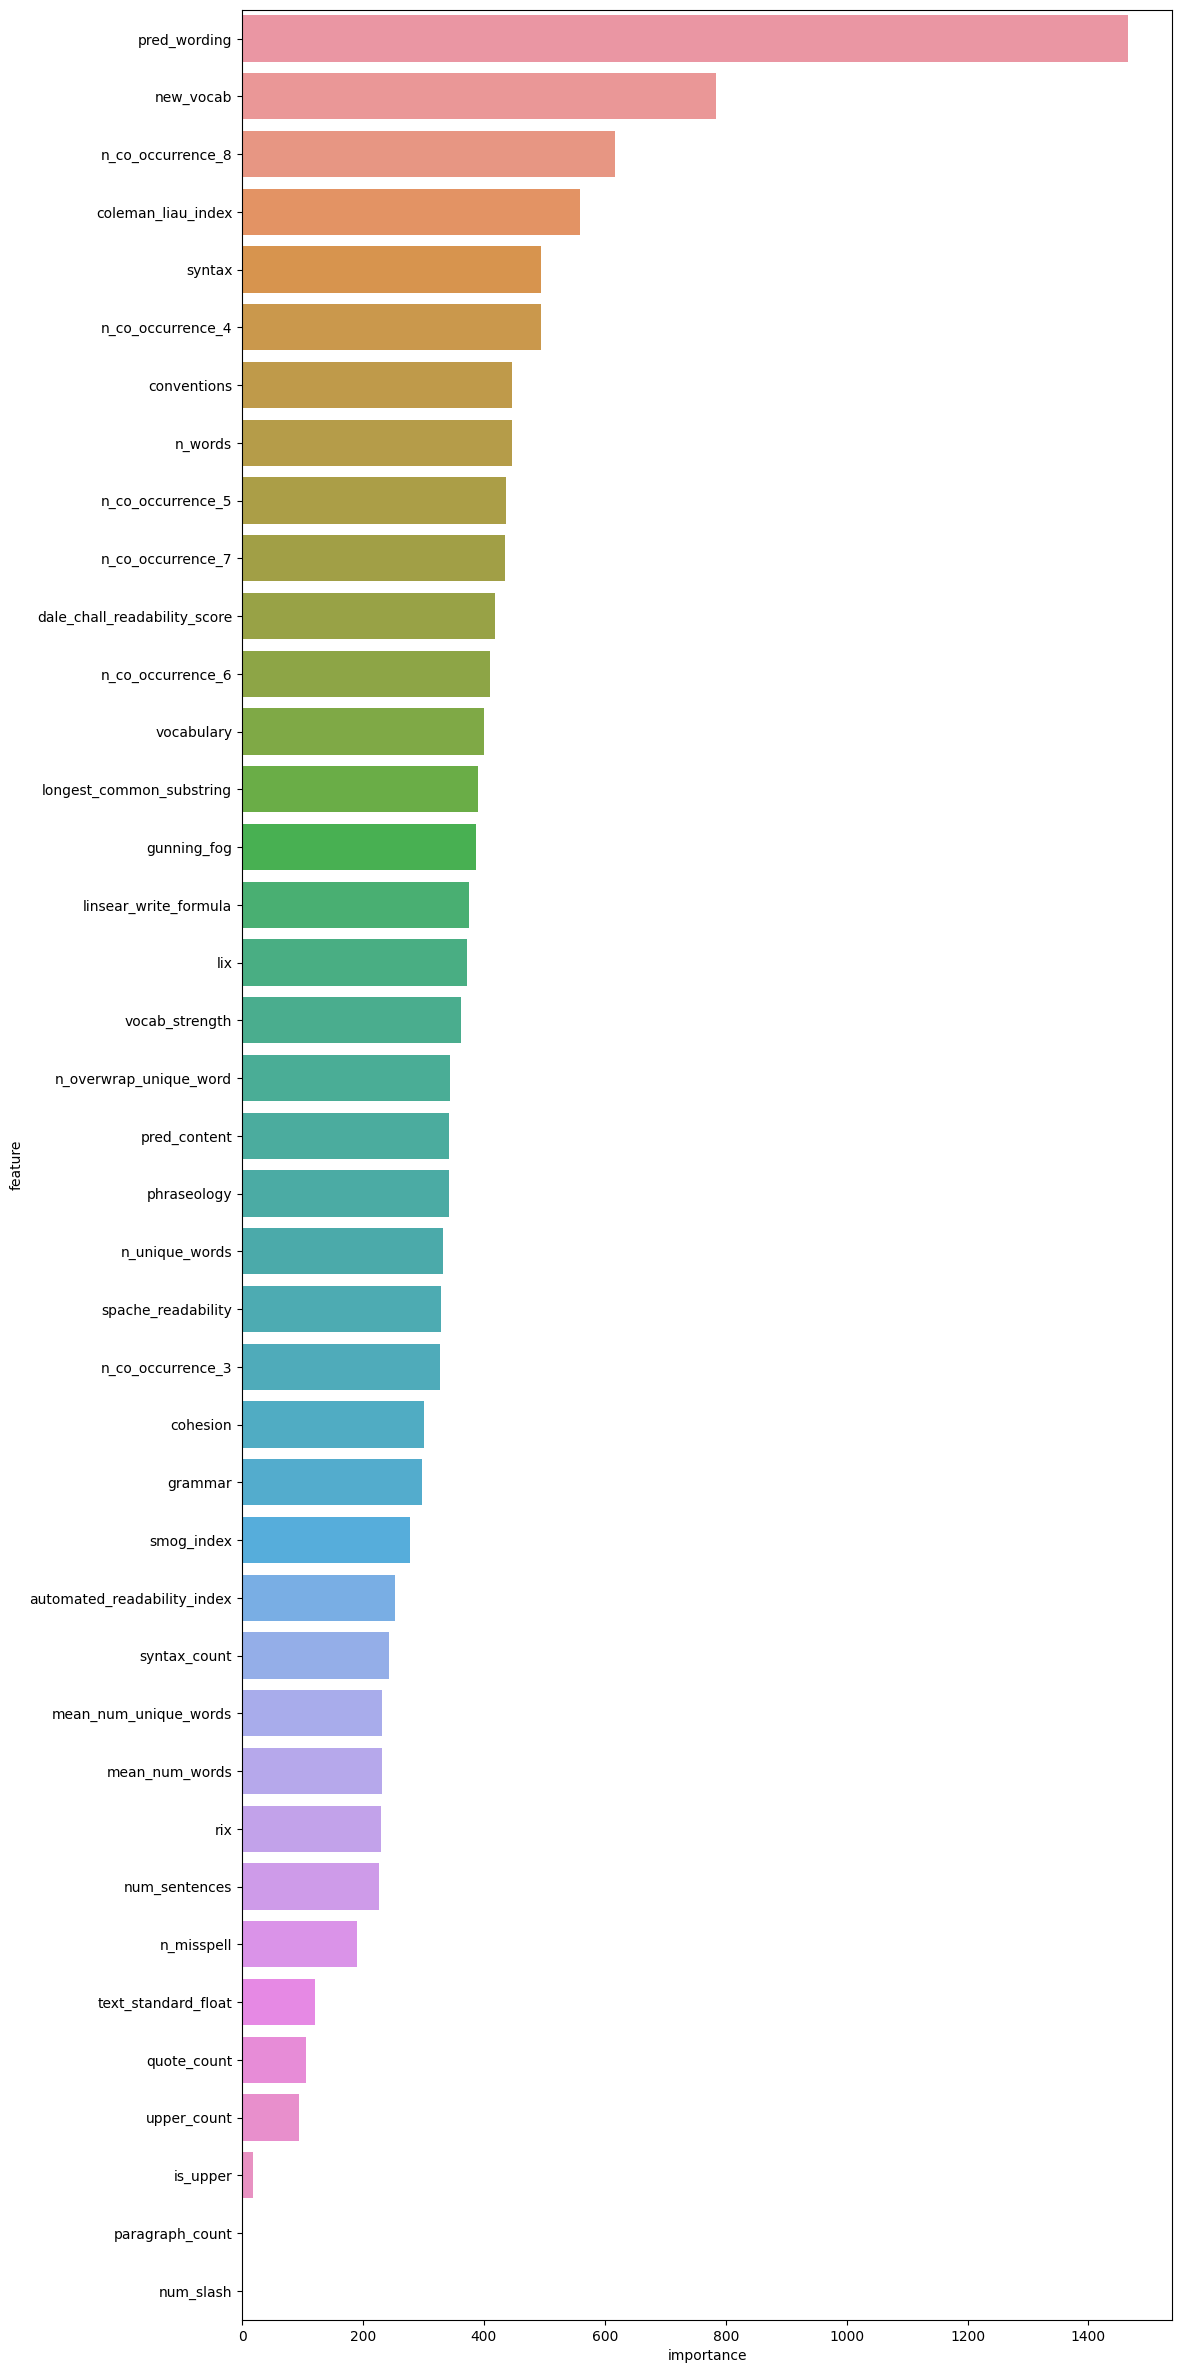

In [32]:
importance_df = pd.DataFrame()
for fold in range(cfg.num_fold):
    model = pickle.load(open(cfg.EXP_MODEL / f"lgbm_fold{fold}_wording.pkl", "rb"))
    _df = pd.DataFrame()
    _df["feature"] = model.feature_name()
    _df["importance"] = model.feature_importance()
    _df["fold"] = fold
    importance_df = pd.concat([importance_df, _df], axis=0)

importance_df.groupby("feature").agg({"importance": ["mean", "std"]}).sort_values(("importance", "mean"), ascending=False)

fig, ax = plt.subplots(figsize=(12, 30))
sns.barplot(x="importance", y="feature", data=importance_df.groupby("feature").agg({"importance": "mean"}).reset_index().sort_values("importance", ascending=False), ax=ax)

In [33]:
!pip install -qq kaggle
from pathlib import PosixPath
from kaggle.api.kaggle_api_extended import KaggleApi
dataset_create_new(dataset_name=Config.NAME, upload_dir=Config.EXP)

Starting upload for file tokenizer.tar


100%|██████████| 2.36M/2.36M [00:00<00:00, 5.85MB/s]


Upload successful: tokenizer.tar (2MB)
Starting upload for file model.tar


100%|██████████| 6.51G/6.51G [01:19<00:00, 88.1MB/s]


Upload successful: model.tar (7GB)
Starting upload for file fig.tar


100%|██████████| 10.0k/10.0k [00:00<00:00, 24.7kB/s]


Upload successful: fig.tar (10KB)
Starting upload for file preds.tar


100%|██████████| 210k/210k [00:00<00:00, 561kB/s]


Upload successful: preds.tar (210KB)
